In [1]:
#Rudimentary analysis on detected POCs including testing the striping method, area histogram, time distribution and some ISCCP data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import scale

import pickle
import os

original_width = 1320  #(a ratio of 0.5)
original_height = 1100  #(a ratio of 0.6)



In [2]:
#import data
# poc_database = joblib.load('/Users/watson-parris/Local Data/POC_data/POC_database_2.dat')
# poc_images = np.load('MODIS_Sc_scenes/numpy_arrays/POC_only_numpy_images.npy')
# poc_masks = np.load('MODIS_Sc_scenes/numpy_arrays/POC_only_masks.npy')

In [3]:
simple_poc_database = "poc_database.csv"

if os.path.isfile(simple_poc_database):
    poc_data = pd.read_csv(simple_poc_database)
else:
    from sklearn.externals import joblib
    poc_database = joblib.load('/Users/watson-parris/Local Data/POC_data/POC_database_2.dat')
    indices = []
    filename_index = 0
    filenames = {}
    filenames_list = []
    for filename, value in poc_database.items():
        filenames[filename] = filename_index
        filenames_list.append(filename)
        for poc in range(value['poc_no']):
            indices.append((filename_index,poc))
        filename_index += 1

    index = pd.MultiIndex.from_tuples(indices, names=['Image', 'POC'])
    # columns = ['Poc Score', 'Area', 'Perimeter', 'Region']
    columns = ['Poc Score', 'Area', 'Perimeter', 'Region']
    poc_data = pd.DataFrame(index=index, columns=columns)

    regions = ['California', "Namibia", "Peru"]

    def get_region(f):

        for region in regions:
            if region.lower() in f:
                return region
        print(f)
        raise ValueError("Unkown region")

    for filename, value in poc_database.items():
        for poc in range(value['poc_no']):
            poc_data.at[(filenames[filename], poc), 'Poc Score'] = value['poc_data'][poc]['poc_score']
            poc_data.at[(filenames[filename], poc), 'Area'] = value['poc_data'][poc]['area']
            poc_data.at[(filenames[filename], poc), 'Perimeter'] = value['poc_data'][poc]['perimeter']
            poc_data.at[(filenames[filename], poc), 'Region'] = get_region(filename)
            poc_data.at[(filenames[filename], poc), 'filename'] = filename
            poc_data.at[(filenames[filename], poc), 'date'] = pd.to_datetime(filename.split('.')[1][1:], format="%Y%j")
            # The original polygon
            poly = Polygon(np.squeeze(value['poc_data'][poc]['contour']))
            # Rescale to account fo image downsampling
            scaled_poly = scale(poly, xfact=original_width/648, yfact=original_height/648, origin=(0, 0))
            poc_data.at[(filenames[filename], poc), 'shape'] = scaled_poly
            poc_data.at[(filenames[filename], poc), 'shp_area'] = scaled_poly.area
    poc_data = poc_data.convert_dtypes()
    
    poc_data.to_csv(simple_poc_database)

In [4]:
poc_data['date'] = pd.to_datetime(poc_data.date)
poc_data = poc_data.sort_values('date')
poc_data

,Image,POC,Poc Score,Area,Perimeter,Region,filename,date,shape,shp_area
3836,2287,0,0.117593,2957.0,333.279218,Namibia,MODIS_Sc_scenes/namibian/MOD021KM.A2005112.103...,2005-04-22,"POLYGON ((1279.259259259259 614.5061728395061,...",10225.108596
903,536,0,0.283833,25882.5,931.192994,California,MODIS_Sc_scenes/californian/MOD021KM.A2005113....,2005-04-23,"POLYGON ((366.6666666666667 658.6419753086419,...",89499.957133
3829,2282,0,0.408525,4841.5,332.208151,Namibia,MODIS_Sc_scenes/namibian/MOD021KM.A2005119.104...,2005-04-29,"POLYGON ((1020.555555555556 903.0864197530864,...",16741.583791
6406,3611,0,0.421939,2799.5,237.237588,Peru,MODIS_Sc_scenes/peruvian/MOD021KM.A2005121.152...,2005-05-01,"POLYGON ((354.4444444444445 736.7283950617284,...",9680.484111
1999,1168,0,0.342695,4582.0,315.906635,California,MODIS_Sc_scenes/californian/MOD021KM.A2005123....,2005-05-03,"POLYGON ((366.6666666666667 280.0925925925926,...",15844.250114
...,...,...,...,...,...,...,...,...,...,...
4797,2795,1,0.226601,1435.5,173.781745,Peru,MODIS_Sc_scenes/peruvian/MOD021KM.A2017364.151...,2017-12-30,"POLYGON ((201.6666666666667 628.0864197530864,...",4963.863169
3620,2151,1,0.333415,23366.5,812.222431,Namibia,MODIS_Sc_scenes/namibian/MOD021KM.A2018101.094...,2018-04-11,"POLYGON ((301.4814814814815 334.4135802469136,...",80799.797096
3619,2151,0,0.210385,5866.0,373.279218,Namibia,MODIS_Sc_scenes/namibian/MOD021KM.A2018101.094...,2018-04-11,"POLYGON ((171.1111111111111 132.4074074074074,...",20284.236397
6150,3491,0,0.297124,3753.5,257.237588,Peru,MODIS_Sc_scenes/peruvian/MOD021KM.A2018106.150...,2018-04-16,"POLYGON ((120.1851851851852 490.5864197530864,...",12979.352423


In [5]:
# Get the largest areas each day
daily_poc_data=poc_data.groupby(['Region', pd.Grouper(freq='1d', key='date')]).max()
daily_poc_data=daily_poc_data.reset_index('date')

In [6]:
# Find consecutive days and then label the nth consecutive day of each 'streak'
daily_poc_data['streak_id'] = daily_poc_data.date.diff().dt.days.ne(1).cumsum()
daily_poc_data['Consecutive Days'] = daily_poc_data.groupby('streak_id').cumcount()

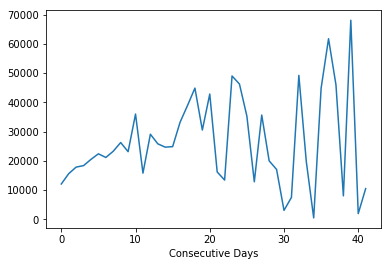

In [7]:
# Plot the average maximum size by the number of consecutive days
daily_poc_data.groupby('Consecutive Days').mean().Area.plot()

[(0, 40000), Text(0,0.5,'Max Area'), (0, 7)]

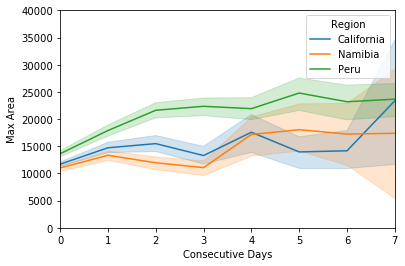

In [8]:
sns.lineplot(data=daily_poc_data, x='Consecutive Days', y='Area', hue='Region', ci=68)
plt.gca().set(xlim=[0, 7], ylim=[0, 40000], ylabel='Max Area')

In [9]:
# Get the number of POCs each day
daily_poc_data_count=poc_data.groupby(['Region', pd.Grouper(freq='1d', key='date')]).count()
daily_poc_data_count=daily_poc_data_count.reset_index('date')

In [10]:
# Find consecutive days and then label the nth consecutive day of each 'streak'
daily_poc_data_count['streak_id'] = daily_poc_data_count.date.diff().dt.days.ne(1).cumsum()
daily_poc_data_count['Consecutive Days'] = daily_poc_data_count.groupby('streak_id').cumcount()

[(0, 6), Text(0,0.5,'No. POCs'), (0, 7)]

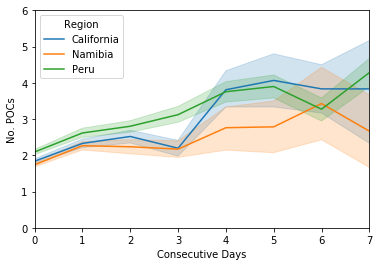

In [11]:
sns.lineplot(data=daily_poc_data_count, x='Consecutive Days', y='Area', hue='Region', ci=68)
plt.gca().set(xlim=[0, 7], ylim=[0,6], ylabel='No. POCs')

In [12]:
# Get the total areas each day
daily_poc_data_sum=poc_data.groupby(['Region', pd.Grouper(freq='1d', key='date')]).sum()
daily_poc_data_sum=daily_poc_data_sum.reset_index('date')

# Find consecutive days and then label the nth consecutive day of each 'streak'
daily_poc_data_sum['streak_id'] = daily_poc_data_sum.date.diff().dt.days.ne(1).cumsum()
daily_poc_data_sum['Consecutive Days'] = daily_poc_data_sum.groupby('streak_id').cumcount()

[(0, 70000), Text(0,0.5,'Total Area'), (0, 7)]

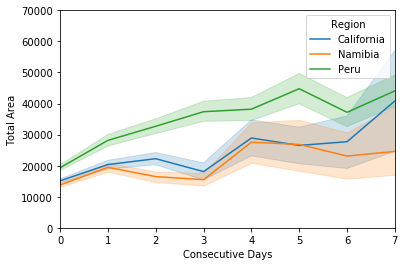

In [13]:
# Plot the average total size by the number of consecutive days
# daily_poc_data_sum.groupby('Consecutive Days').median().Area.plot()
sns.lineplot(data=daily_poc_data_sum, x='Consecutive Days', y='Area', hue='Region', ci=68)
plt.gca().set(xlim=[0, 7], ylim=[0, 70000], ylabel='Total Area')

So, the number of POCs increases, the maximum size increases and the total size increases over the course of 1-2 weeks (on average)

[Text(0,0.5,'Absolute No. POCs'), (0, 7)]

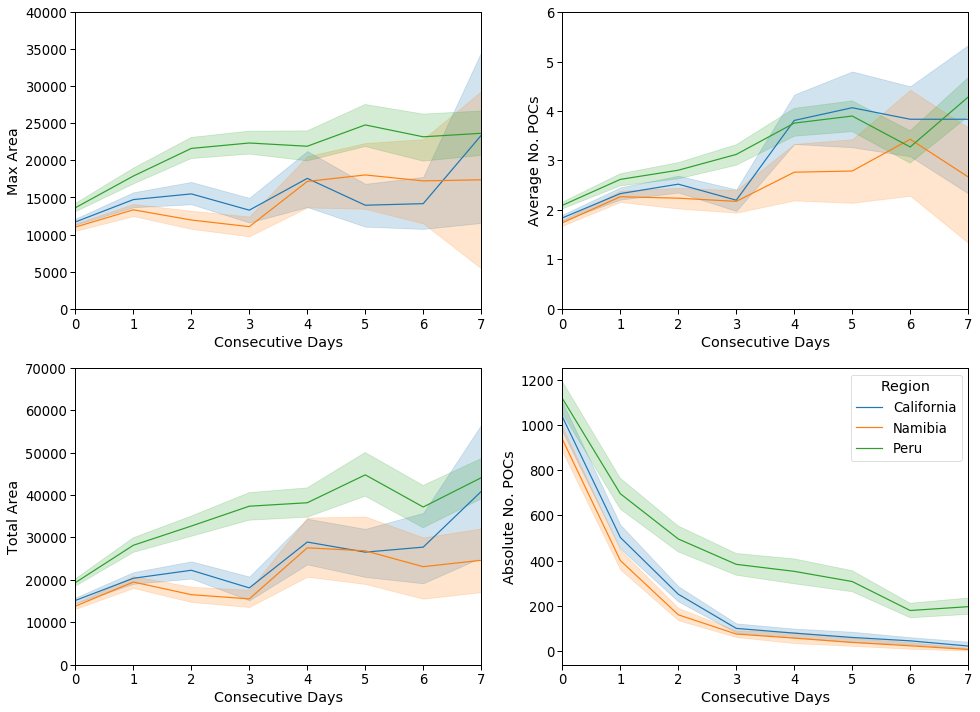

In [31]:
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

sns.lineplot(data=daily_poc_data, x='Consecutive Days', y='Area', hue='Region', ci=68, ax=ax[0,0], legend=False)
ax[0,0].set(xlim=[0, 7], ylim=[0, 40000], ylabel='Max Area')

sns.lineplot(data=daily_poc_data_count, x='Consecutive Days', y='Area', hue='Region', ci=68, ax=ax[0,1], legend=False)
ax[0,1].set(xlim=[0, 7], ylim=[0,6], ylabel='Average No. POCs')

sns.lineplot(data=daily_poc_data_sum, x='Consecutive Days', y='Area', hue='Region', ci=68, ax=ax[1,0], legend=False)
ax[1,0].set(xlim=[0, 7], ylim=[0, 70000], ylabel='Total Area')

sns.lineplot(data=daily_poc_data_count, x='Consecutive Days', y='POC', hue='Region', estimator='sum', ax=ax[1,1])
ax[1,1].set(xlim=[0, 7], ylabel='Absolute No. POCs')



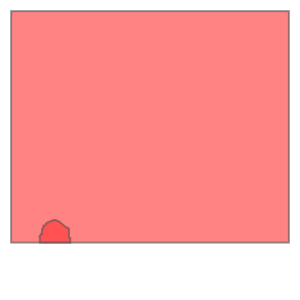

In [63]:
def poc_context(poc):
#     return MultiPolygon([Polygon([(0,0), (0,648), (648,648), (648, 0)]), poc])
    return MultiPolygon([Polygon([(0,0), (0,original_height), (original_width, original_height), (original_width, 0)]), poc])

poc_context(poc_data.loc[(1, 0), 'shape'])

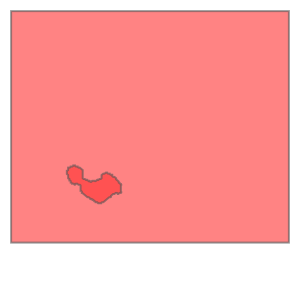

In [64]:
poc_context(poc_data.loc[(1, 1), 'shape'])

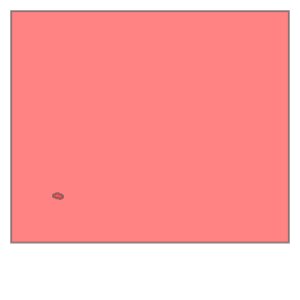

In [65]:
poc_context(poc_data.loc[(1, 2), 'shape'])

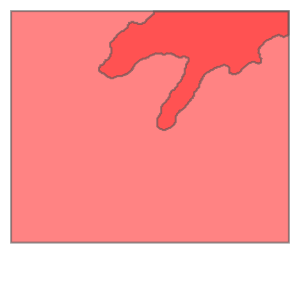

In [66]:
poc_context(poc_data.loc[(3524, 0), 'shape'])

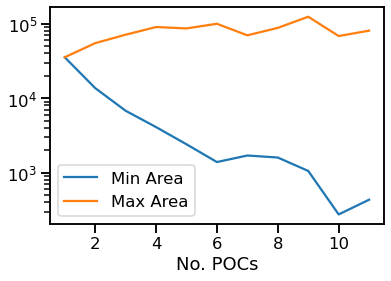

In [105]:
# Find the average min/max POC area as a function of the number of POCs in the image

freq_df=pd.DataFrame({"No. POCs": poc_data.reset_index().groupby("Image").POC.count(), 
                      "Area": poc_data.reset_index().groupby("Image").shp_area.mean(), 
                      "Total Area": poc_data.reset_index().groupby("Image").shp_area.sum(),
                      "Min Area": poc_data.reset_index().groupby("Image").shp_area.min(),
                     "Max Area": poc_data.reset_index().groupby("Image").shp_area.max()})
freq_df.groupby("No. POCs").mean()[['Min Area', 'Max Area']].plot()
plt.yscale('log')

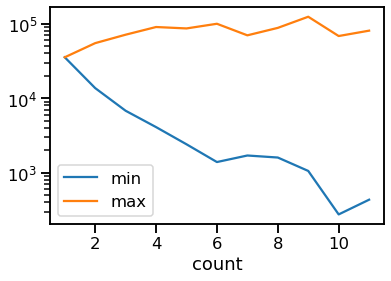

In [113]:
# Or in one line...
poc_data.reset_index().groupby("Image").shp_area.agg(['count', 'min', 'max']).groupby("count").mean().plot()
plt.yscale('log')

In [121]:
# OR, plot the average size of the nth POC in an image, sorted by size
# Sort the POCs by size in each image
new_poc_df = poc_data.reset_index().sort_values(["Image", "shp_area"], ascending=[True, False]).set_index("Image")
# Create a new index based on that sorted ordering of POCs
new_poc_df = new_poc_df.set_index(new_poc_df.groupby('Image').cumcount(), append=True)

Text(0, 0.5, 'Area (km$^2$)')

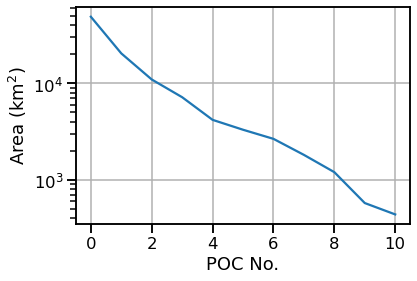

In [141]:
# Plot the mean area as a function of the (sorted) POC number
ax=new_poc_df.reset_index().rename(columns={"level_1":"POC No."}).groupby('POC No.').mean().shp_area.plot()
plt.yscale('log')
ax.grid()
# ax.set_title(r)
# ax.set_xticklabels([f"$10^{int(t)}$" for t in ax.get_xticks()])
ax.set_ylabel("Area (km$^2$)")

In [5]:
# print(len(filenames_list))
#print(filenames_list)

In [6]:
# import pickle
# with open('MODIS_Sc_scenes/numpy_arrays/POC_filenames.dat', 'rb') as f:
#         POC_filenames = pickle.load(f)
# with open('MODIS_Sc_scenes/numpy_arrays/poc_filenames.dat', 'rb') as f:
#         poc_filenames = pickle.load(f)
# with open('MODIS_Sc_scenes/numpy_arrays/filename_list', 'rb') as f:
#         filename_list = pickle.load(f)
        
# print(len(POC_filenames))
# print(len(poc_filenames))
# print(len(filename_list))

In [7]:
# full_size_poc_masks = np.load('MODIS_Sc_scenes/numpy_arrays/full_size_POC_only_masks.npy')
# print(full_size_poc_masks.shape)
# del full_size_poc_masks

In [8]:
#, dtype=['float32', 'float32', 'float32', 'string'])

In [27]:
poc_data.dtypes

Poc Score            object
Area                 object
Perimeter            object
Region               object
filename             object
date         datetime64[ns]
shape                object
shp_area            float64
dtype: object

# POC area distributions

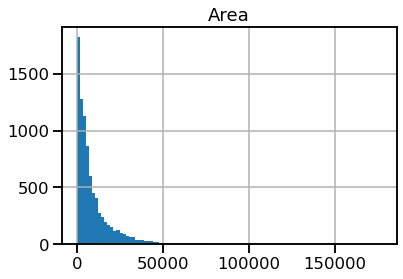

In [46]:
hist = poc_data.hist(bins=100, column='Area')

In [47]:
poc_data_reduced = poc_data[np.logical_and(poc_data['Poc Score'] > 0, poc_data['Poc Score'] < 1)]
poc_data_reduced = poc_data_reduced[poc_data_reduced['Area'] < 75000]
poc_data_reduced = poc_data_reduced[poc_data_reduced['Area'] > 1000]
#poc_data_reduced = poc_data
print(poc_data_reduced)

           Poc Score     Area   Perimeter      Region  \
Image POC                                               
0     0     0.326486   8823.5  408.717817  California   
      1     0.283142   3108.5  271.923880  California   
1     0     0.239150   3528.0  243.882250  California   
      1     0.238492   6601.5  454.717817  California   
      5     0.149041   4325.0  291.823375  California   
...              ...      ...         ...         ...   
4726  3     0.253750   2868.0  281.681239        Peru   
      4     0.459085   7284.5  367.379724        Peru   
4727  0     0.340845  23830.0  740.676187        Peru   
      1     0.282929   8472.0  471.279218        Peru   
4728  0     0.386173   6450.5  367.521859        Peru   

                                                    filename       date  \
Image POC                                                                 
0     0    MODIS_Sc_scenes/californian/MOD021KM.A2013054.... 2013-02-23   
      1    MODIS_Sc_scenes/califo

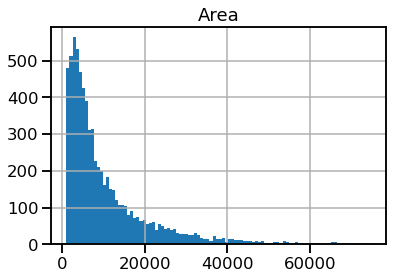

In [48]:
fig, ax = plt.subplots()
hist = poc_data_reduced.hist(ax=ax, bins=100, column='Area')

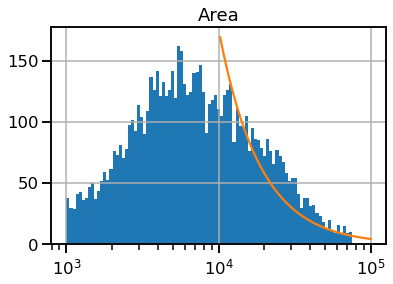

In [49]:
fig, ax = plt.subplots()
x=np.logspace(3, 5, num=100)

hist = poc_data_reduced.hist(ax=ax, column='Area', bins=x)

# ax.plot(x, 1e4*(x/800)**-1.6)
ax.plot(x[50:], 1e4*(x[50:]/800)**-1.6)
ax.set_xscale('log')
# ax.set_yscale('log')

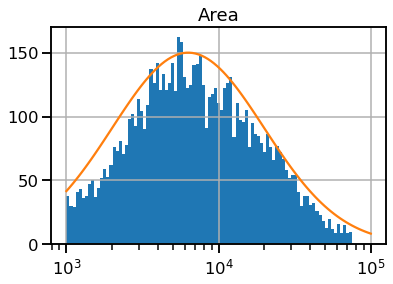

In [50]:
fig, ax = plt.subplots()
x=np.logspace(3, 5, num=100)

hist = poc_data_reduced.hist(ax=ax, column='Area', bins=x)

# ax.plot(x, 1e4*(x/800)**-1.6)
ax.plot(x, 300*np.exp(((-(np.log10(x)-3.8)**2)/2*2**2))/2)
ax.set_xscale('log')
# ax.set_yscale('log')

(3.847698396597505, 0.4031885915032473)


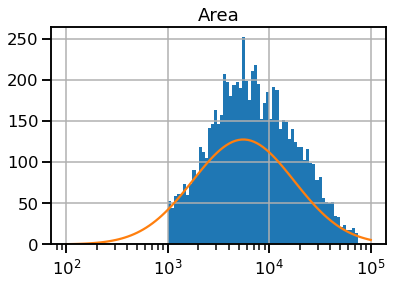

In [51]:
import scipy.stats
params = scipy.stats.norm.fit(np.log10(poc_data_reduced['Area']), loc=poc_data_reduced['Area'].median(), scale=0.5)
print(params)

fig, ax = plt.subplots()
x=np.logspace(2, 5, num=100)

hist = poc_data_reduced.hist(ax=ax, column='Area', bins=x)

# ax.plot(x, 180*scipy.stats.norm.pdf(np.log10(x), *params))
# ax.plot(x, 180*scipy.stats.lognorm.pdf(x, 10, 3900, 1))
ax.plot(x, 160*scipy.stats.norm.pdf(np.log10(x), np.log10(5544.0), 0.5))
ax.set_xscale('log')
# ax.set_yscale('log')

(3.847698396597505, 0.4031885915032473)


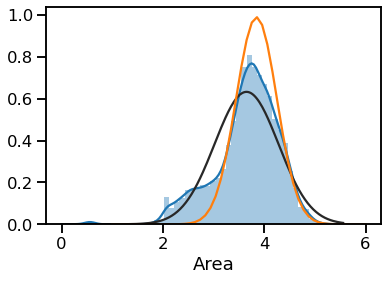

In [52]:
import seaborn as sns
params = scipy.stats.norm.fit(np.log10(poc_data_reduced['Area']), loc=poc_data_reduced['Area'].median(), scale=0.5)
print(params)

fig, ax = plt.subplots()
# x=np.logspace(3, 5, num=100)
x=np.linspace(1, 6)

hist = sns.distplot(np.log10(poc_data['Area']), ax=ax, bins=x, fit=scipy.stats.norm)
# hist = sns.distplot(np.log10(poc_data_reduced['Area']), ax=ax, fit=scipy.stats.norm)

ax.plot(x, scipy.stats.norm.pdf(x, *params))
# ax.plot(x, 180*scipy.stats.lognorm.pdf(x, 10, 3900, 1))
# ax.plot(x, 160*scipy.stats.norm.pdf(np.log10(x), np.log10(5544.0), 0.5))
# ax.set_xscale('log')
# ax.set_yscale('log')

6753.75 354.8133892335753


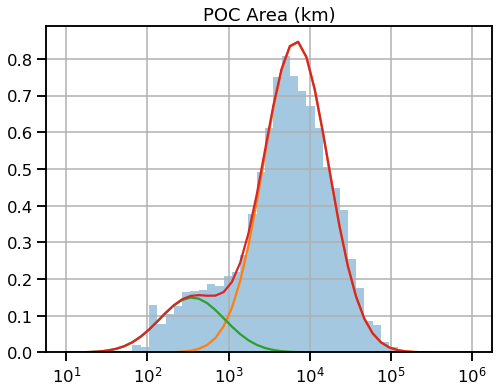

In [53]:

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,6))
x=np.linspace(1, 6)

hist = sns.distplot(np.log10(poc_data['Area']), ax=ax, bins=x, kde=False, norm_hist=True)

y1_mu = poc_data_reduced['Area'].median()
y2_mu = 10**2.55
print(y1_mu, y2_mu)

y1 = 0.85*scipy.stats.norm.pdf(x, np.log10(y1_mu), 0.4)
y2 = 0.15*scipy.stats.norm.pdf(x, np.log10(y2_mu), 0.4)
ax.plot(x, y1)
ax.plot(x, y2)
ax.plot(x, y1+y2)
ax.grid()
ax.set_xticklabels([f"$10^{int(t)}$" for t in ax.get_xticks()])
_=ax.set_xlabel('')
_=ax.set_title('POC Area (km)')

Text(0, 0.5, 'Probability (1)')

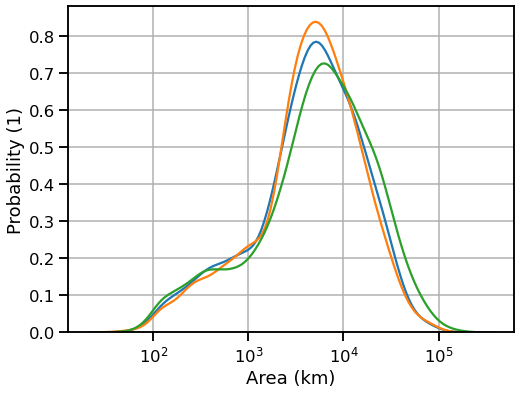

In [97]:
fig, ax = plt.subplots(figsize=(8,6))
x=np.linspace(1, 6)

for r in regions:
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6])

ax.grid()
ax.set_xticklabels([f"$10^{int(t)}$" for t in ax.get_xticks()])
ax.set_xlabel("Area (km)")
ax.set_ylabel("Probability (1)")

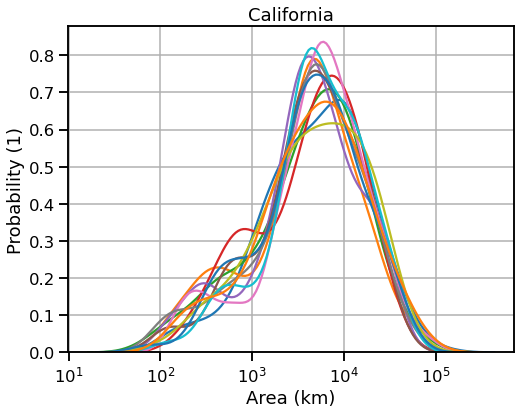

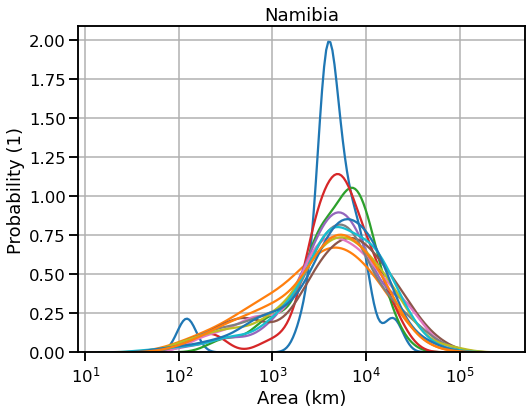

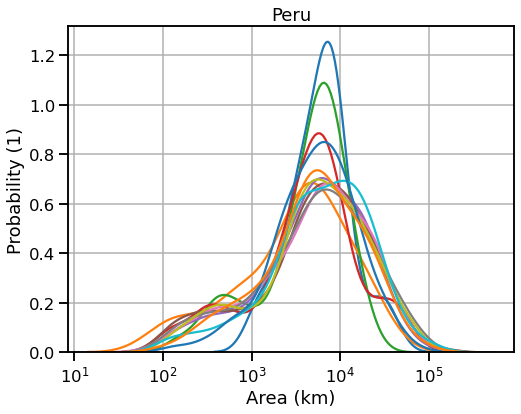

In [101]:
for r in regions:
    fig, ax = plt.subplots(figsize=(8,6))
    
    r_df = poc_data[poc_data.Region==r]

    for s, df in r_df.groupby(pd.DatetimeIndex(r_df.date).month):
        hist = sns.kdeplot(np.log10(df['Area']), legend=False, clip=[1,6])

    ax.grid()
    ax.set_title(r)
    ax.set_xticklabels([f"$10^{int(t)}$" for t in ax.get_xticks()])
    ax.set_xlabel("Area (km)")
    ax.set_ylabel("Probability (1)")

[2.51685229e+00 3.16747090e-01 6.64149795e+01 3.82247413e+00
 4.54356103e-01 3.27900228e+02] 
 [0.03523751 0.03564909 5.31086019 0.00841432 0.00925561 4.54992186]


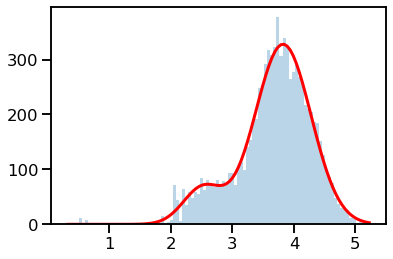

In [58]:
# from pylab import *
from scipy.optimize import curve_fit

# data=concatenate((normal(1,.2,5000),normal(2,.2,2500)))
y,x,_=plt.hist(np.log10(poc_data['Area']),100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(3,0.5,60,3.6,.5,200)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(np.diag(cov))
plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
# legend()
print(params,'\n',sigma)    

In [59]:
print(poc_data_reduced['Area'].median())
print(np.log10(poc_data_reduced['Area']).mean())

6753.75
3.847698396597505


In [60]:
print('Averages:')
averages = poc_data_reduced.mean(axis=0)
print(averages['Area'])
print('POC Score:', averages['Poc Score'])
print('Area: ', averages['Area'], 'km^2')
print('Perimeter: ', averages['Perimeter'], 'km')


Averages:
10819.679961357991
POC Score: 0.3197770127150452
Area:  10819.679961357991 km^2
Perimeter:  537.9202908120891 km


# Extreme POCs

In [ ]:
poc_data.idxmin(axis=0)

In [ ]:
image = 3426
poc = 1
plt.imshow(poc_images[image,...])

In [ ]:
test_filename = (list(filenames.keys())[list(filenames.values()).index(image)])
tempmask=np.zeros((648,648), dtype='bool')
for poc in poc_database[test_filename]['poc_data']:
    tempmask=tempmask+poc['mask']
plt.imshow(tempmask)

In [ ]:
poc_data_reduced.loc[(189,0)]

# Temporal variablity

In [15]:

def find_month(day):
    assert day >= 0 and day <= 365
    months=[31,59,90,120,151,181,212,243,273,304,334,365]
    for i in range(len(months)):
        if day <= months[i]:
            return i

name_convert = {'peruvian':'per', 'californian':'cal', 'namibian':'nam'}
length = 12
time_dist = {}
time_dist_count = {}
time_dist_mean = {}
time_dist_norm = {}

time_dist['peruvian'] = [0]*length
time_dist['namibian'] = [0]*length
time_dist['californian'] = [0]*length

time_dist_count['peruvian'] = [0]*length
time_dist_count['namibian'] = [0]*length
time_dist_count['californian'] = [0]*length

time_dist_mean['peruvian'] = [0]*length
time_dist_mean['namibian'] = [0]*length
time_dist_mean['californian'] = [0]*length

time_dist_norm['peruvian'] = [0]*length
time_dist_norm['namibian'] = [0]*length
time_dist_norm['californian'] = [0]*length

with open('stratocumulus_amount.pickle', 'rb') as handle:
#with open('cloud_averages.pickle', 'rb') as handle:
    cloud_averages = pickle.load(handle)
    
scaled_cloud_averages = {}
for key, value in cloud_averages.items():
    scaled_cloud_averages[key] = [0]*length
    for i in range(len(value)):
        scaled_cloud_averages[key][i] = (value[i]-min(value))/(max(value)-min(value))

for filename in filenames_list: #all filenames
    place = filename.split('/')[1]
    day = int(filename.split('.')[1][5:])-1
    month = find_month(day)
    time_dist_count[place][month] += 1
        
for filename in filenames_list: #poc filenames
    place = filename.split('/')[1]
    day = int(filename.split('.')[1][5:])-1
    month = find_month(day)
    time_dist[place][month] += poc_database[filename]['poc_no']

for i in range(length):
    for key, value in time_dist.items():
        if time_dist_count[key][i] != 0:
            time_dist_mean[key][i] = time_dist[key][i]/time_dist_count[key][i]

for i in range(length):
    for key, values in time_dist.items():
        #time_dist_norm[key][i] = time_dist[key][i]*(1-scaled_cloud_averages[name_convert[key]][i])
        time_dist_norm[key][i] = 100*time_dist_mean[key][i]/(cloud_averages[name_convert[key]][i])
        #time_dist_norm[key][i] = time_dist[key][i]*(100-cloud_averages[name_convert[key]][i])

In [16]:
min(time_dist_norm['californian'])

4.026515860635268

Text(0.5, 0, 'Month')

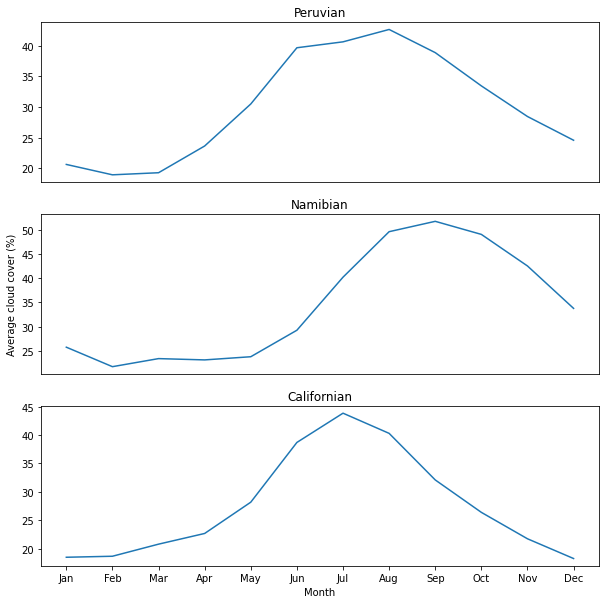

In [19]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
f = plt.figure(figsize = (10,10))
kernelsize = 1
f.add_subplot(3, 1, 1)
plt.plot(movingaverage(cloud_averages['per'], kernelsize))
plt.title('Peruvian')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
f.add_subplot(3, 1, 2)
plt.plot(movingaverage(cloud_averages['nam'], kernelsize))
plt.title('Namibian')
plt.ylabel('Average cloud cover (%)')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
f.add_subplot(3, 1, 3)
plt.plot(movingaverage(cloud_averages['cal'], kernelsize))
plt.title('Californian')
plt.xticks(np.arange(12), months)
plt.xlabel('Month')

In [18]:
def movingaverage(interval, window_size): 
    interval = np.asarray(interval) 
    window = np.ones(int(window_size))/float(window_size) 
    return np.convolve(interval, window, 'same')

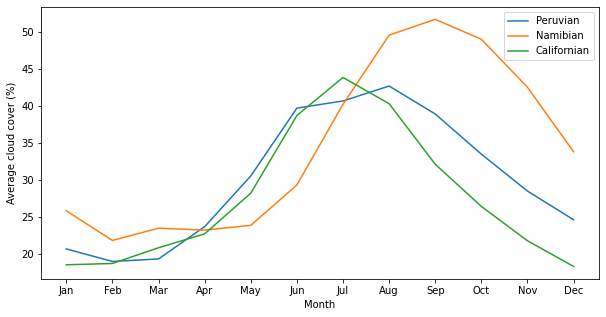

In [20]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
f = plt.figure(figsize = (10,5))
kernelsize = 1
Peruvian, = plt.plot(movingaverage(cloud_averages['per'], kernelsize))
Namibian, = plt.plot(movingaverage(cloud_averages['nam'], kernelsize))
Californian, = plt.plot(movingaverage(cloud_averages['cal'], kernelsize))
plt.ylabel('Average cloud cover (%)')
plt.xticks(np.arange(12), months)
plt.xlabel('Month')
plt.legend(handles=[Peruvian, Namibian, Californian], labels=['Peruvian', 'Namibian', 'Californian'])


def movingaverage(interval, window_size):
    interval = np.asarray(interval)
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Text(0.5, 0, 'Month')

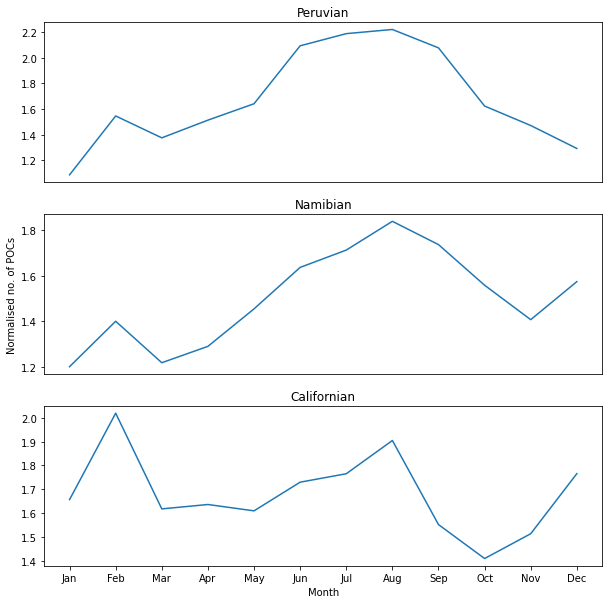

In [21]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
f = plt.figure(figsize = (10,10))
kernelsize = 1
f.add_subplot(3, 1, 1)
plt.plot(movingaverage(time_dist_mean['peruvian'], kernelsize))
plt.title('Peruvian')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
f.add_subplot(3, 1, 2)
plt.plot(movingaverage(time_dist_mean['namibian'], kernelsize))
plt.title('Namibian')
plt.ylabel('Normalised no. of POCs')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
f.add_subplot(3, 1, 3)
plt.plot(movingaverage(time_dist_mean['californian'], kernelsize))
plt.title('Californian')
plt.xticks(np.arange(12), months)
plt.xlabel('Month')


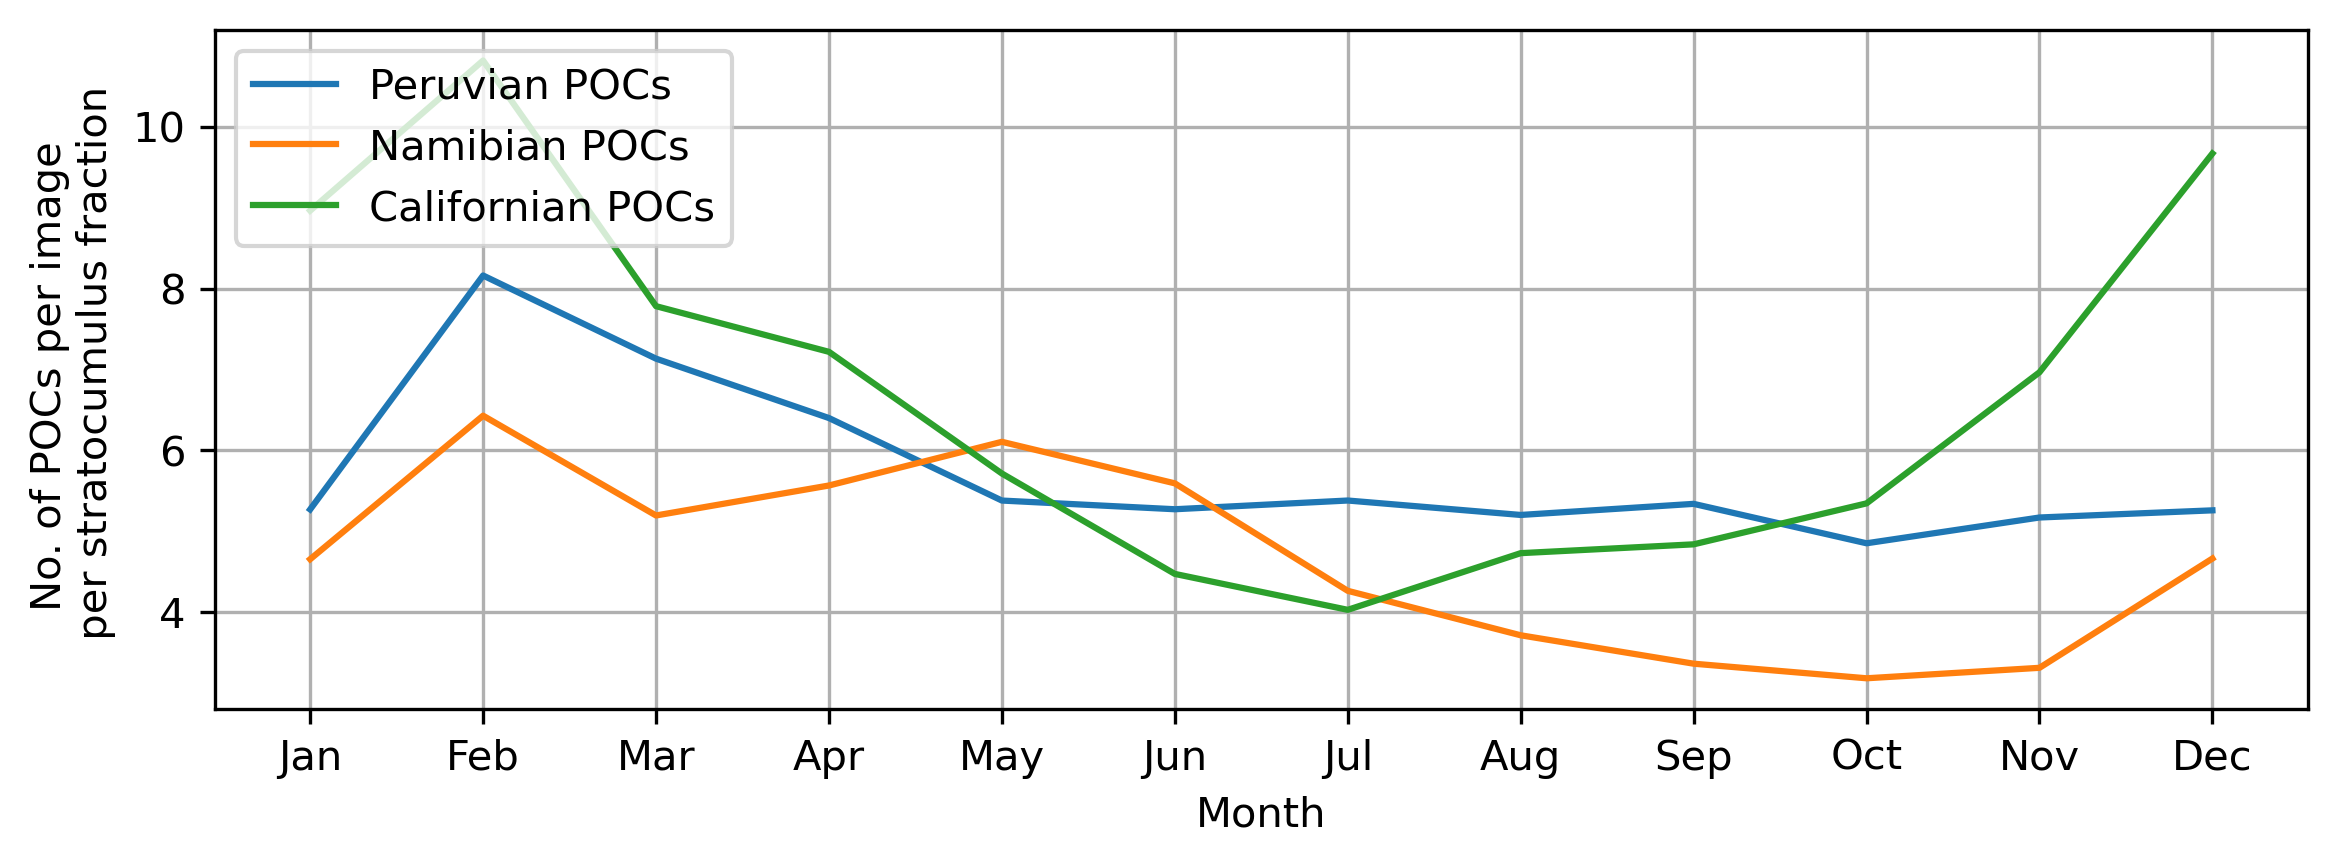

In [27]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
f = plt.figure(figsize = (9,3), dpi=300)
kernelsize = 1
Peruvian, = plt.plot(movingaverage(time_dist_norm['peruvian'], kernelsize))
Namibian, = plt.plot(movingaverage(time_dist_norm['namibian'], kernelsize))
Californian, = plt.plot(movingaverage(time_dist_norm['californian'], kernelsize))
plt.ylabel('No. of POCs per image \n per stratocumulus fraction')
#plt.twinx()
#Peruvian_cld, = plt.plot(movingaverage(cloud_averages['per'], kernelsize), ls= ':')
#Namibian_cld, = plt.plot(movingaverage(cloud_averages['nam'], kernelsize), ls= ':')
#Californian_cld, = plt.plot(movingaverage(cloud_averages['cal'], kernelsize), ls= ':')
#plt.ylabel('Average cloud cover (%)')
plt.xticks(np.arange(12), months)
plt.xlabel('Month')
plt.legend(handles=[Peruvian, Namibian, Californian], labels=['Peruvian POCs', 'Namibian POCs', 'Californian POCs'], loc='upper left')
plt.grid(b=True)
#plt.legend(handles=[Peruvian, Namibian, Californian, Peruvian_cld, Namibian_cld, Californian_cld], labels=['Peruvian POCs', 'Namibian POCs', 'Californian POCs', 'Peruvian cloud amount', 'Namibian cloud amount', 'Californian cloud amount'])



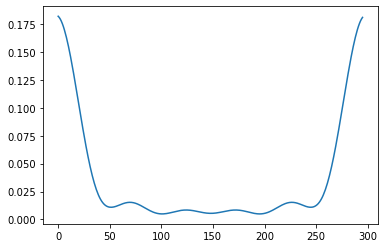

In [23]:
kernelsize=300
freq = np.abs(np.fft.fft(movingaverage(time_dist_mean['peruvian'], kernelsize)))
plt.plot(freq[2:-2])

In [24]:
year_dist = {}
year_dist_count = {}
year_dist_mean = {}
year_dist['peruvian'] = [0]*14
year_dist['namibian'] = [0]*14
year_dist['californian'] = [0]*14

year_dist_count['peruvian'] = [0]*14
year_dist_count['namibian'] = [0]*14
year_dist_count['californian'] = [0]*14

year_dist_mean['peruvian'] = [0]*14
year_dist_mean['namibian'] = [0]*14
year_dist_mean['californian'] = [0]*14
test=[]
for filename in filenames_list:
    place = filename.split('/')[1]
    year = int(filename.split('.')[1][1:5])-2005
    year_dist[place][year] += poc_database[filename]['poc_no']
    year_dist_count[place][year] += 1

for i in range(14):
    for key, value in year_dist.items():
        if year_dist_count[key][i] != 0:
            year_dist_mean[key][i] = year_dist[key][i]/year_dist_count[key][i]


Text(0.5, 0, 'Year')

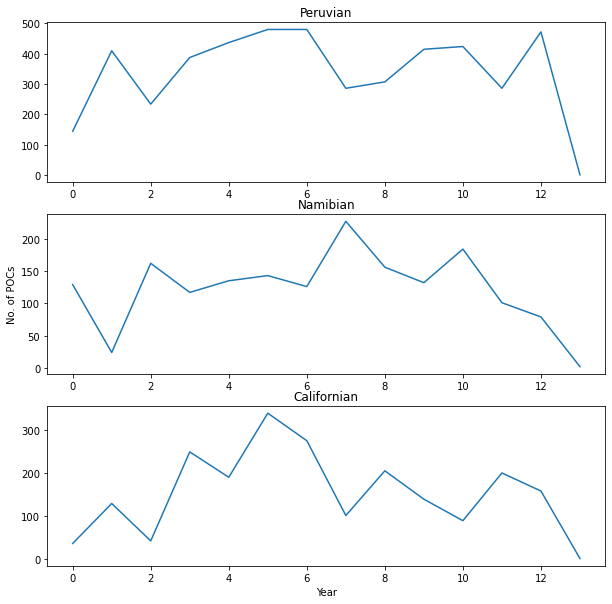

In [25]:
f = plt.figure(figsize = (10,10))
kernelsize = 1
f.add_subplot(3, 1, 1)
plt.plot(year_dist['peruvian'])
plt.title('Peruvian')
f.add_subplot(3, 1, 2)
plt.plot(year_dist['namibian'])
plt.title('Namibian')
plt.ylabel('No. of POCs')
f.add_subplot(3, 1, 3)
plt.plot(year_dist['californian'])
plt.title('Californian')
plt.xlabel('Year')